# GP multi-sorties pour pricer un straddle

In [239]:
import math
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

In [240]:
# =========================
#        Black–Scholes
# =========================
def bs_call(S, K=100, r=0.01, sigma=0.2, T=1.0):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def bs_put(S, K=100, r=0.01, sigma=0.2, T=1.0):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

In [241]:
# =========================
#  Multitask GP Model
# =========================
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), 
            num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.MaternKernel(nu=2.5)
            ),
            num_tasks=2,
            rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [242]:
# =========================
#       Paramètres
# =========================
r = 0.0
K_call = 100.0
K_put  = 100.0
sigma = 0.3
T = 2.0
lb, ub = 0.001, 200.0
n_train = 20
n_test = 200

S_train = np.linspace(lb, ub, n_train)
S_test  = np.linspace(lb, ub, n_test)
train_x = torch.linspace(0, 1.0, n_train)
test_x  = torch.linspace(0, 1.0, n_test)

call_train = bs_call(S_train, K_call, r, sigma, T)
put_train  = bs_put(S_train,  K_put,  r, sigma, T)
call_true  = bs_call(S_test,  K_call, r, sigma, T)
put_true   = bs_put(S_test,   K_put,  r, sigma, T)

train_y = torch.stack([
    torch.FloatTensor(call_train),
    torch.FloatTensor(put_train)
], dim=1)

In [243]:
# =========================
#      Modèle & entraînement
# =========================
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for _ in range(300):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

In [244]:
# =========================
#    Prédiction et affichage
# =========================
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    y_hat = likelihood(model(test_x))

mean_preds = y_hat.mean
lower, upper = y_hat.confidence_region()

call_pred = mean_preds[:,0].numpy()
put_pred  = mean_preds[:,1].numpy()
straddle_pred = call_pred + put_pred
straddle_true = call_true + put_true

In [245]:
# =========================
#     Matrice de covariance
# =========================
with torch.no_grad():
    A = model.covar_module.task_covar_module.covar_factor.clone().detach()
    V = model.covar_module.task_covar_module.var.clone().detach()
    outputscale = model.covar_module.data_covar_module.outputscale.item()
    Omega = (A @ A.T)*outputscale + torch.diag(V)

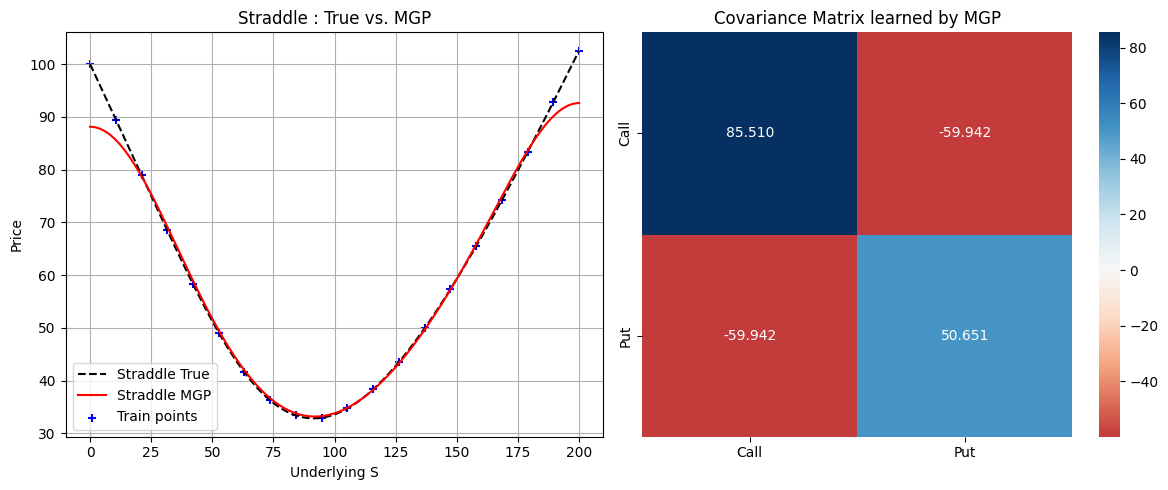

In [246]:
# =========================
#     Subplots
# =========================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# --- (1) Straddle ---
ax1.plot(S_test, straddle_true, 'k--', label='Straddle True')
ax1.plot(S_test, straddle_pred, 'r-', label='Straddle MGP')
ax1.scatter(S_train, call_train + put_train, color='b', marker='+', s=30, label='Train points')
ax1.set_title("Straddle : True vs. MGP")
ax1.set_xlabel("Underlying S")
ax1.set_ylabel("Price")
ax1.grid(True)
ax1.legend()

# --- (2) Covariance ---
sns.heatmap(Omega.numpy(), annot=True, fmt=".3f", cmap="RdBu", center=0,
            xticklabels=["Call", "Put"], yticklabels=["Call", "Put"], ax=ax2)
ax2.set_title("Covariance Matrix learned by MGP")

plt.tight_layout()
plt.show()

In [250]:
# =========================
#       Boucle sur n_train
# =========================
r = 0.0
K_call = 100.0
K_put  = 100.0
sigma = 0.3
T = 2.0
lb, ub = 0.001, 250.0
n_test = 200
S_test = np.linspace(lb, ub, n_test)
call_true = bs_call(S_test, K_call, r, sigma, T)
put_true = bs_put(S_test, K_put, r, sigma, T)
straddle_true = call_true + put_true

results = []

for n_train in range(5, 105, 1):
    S_train = np.linspace(lb, ub, n_train)
    train_x = torch.linspace(0, 1.0, n_train)
    call_train = bs_call(S_train, K_call, r, sigma, T)
    put_train  = bs_put(S_train,  K_put,  r, sigma, T)

    train_y1 = torch.FloatTensor(call_train)
    train_y2 = torch.FloatTensor(put_train)
    train_y = torch.stack([train_y1, train_y2], -1)

    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
    model = MultitaskGPModel(train_x, train_y, likelihood)

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for _ in range(300): 
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    test_x = torch.linspace(0, 1.0, n_test)
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        y_hat = likelihood(model(test_x))
    mean_preds = y_hat.mean

    call_pred = mean_preds[:,0].numpy()
    put_pred  = mean_preds[:,1].numpy()
    straddle_pred = call_pred + put_pred

    mse_call = mean_squared_error(call_true, call_pred)
    mse_put  = mean_squared_error(put_true,  put_pred)
    mse_straddle = mean_squared_error(straddle_true, straddle_pred)

    with torch.no_grad():
        A = model.covar_module.task_covar_module.covar_factor.clone().detach()
        V = model.covar_module.task_covar_module.var.clone().detach()
        outputscale = model.covar_module.data_covar_module.outputscale.item()
        Omega = (A @ A.T)*outputscale + torch.diag(V)
        cov_call_put = Omega[0,1].item()

    results.append((n_train, mse_call, mse_put, mse_straddle, cov_call_put))

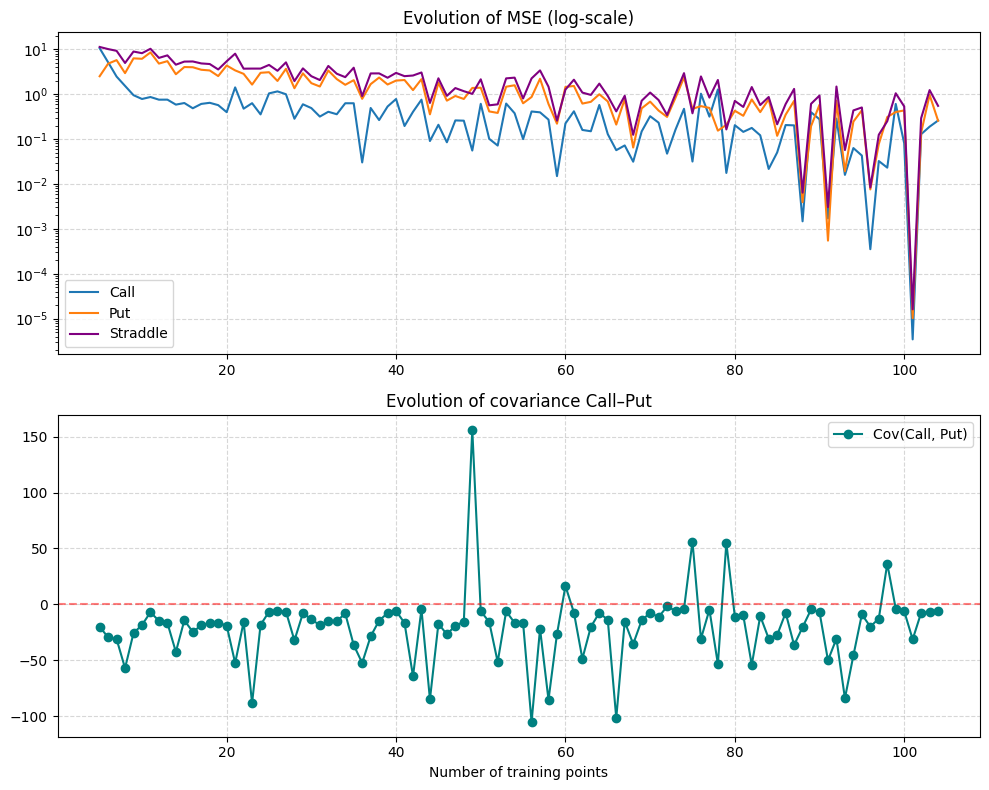

In [251]:
# =========================
#       Affichage
# =========================
df = pd.DataFrame(results, columns=["n_train", "MSE_Call", "MSE_Put", "MSE_Straddle", "Cov_Call_Put"])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))

# 1) MSE
ax1.plot(df["n_train"], df["MSE_Call"], label="Call")
ax1.plot(df["n_train"], df["MSE_Put"],  label="Put")
ax1.plot(df["n_train"], df["MSE_Straddle"], label="Straddle", color='purple')
ax1.set_yscale('log')
ax1.set_title("Evolution of MSE (log-scale)")
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.5)

# 2) Cov(Call, Put)
ax2.plot(df["n_train"], df["Cov_Call_Put"], marker='o', color='teal', label="Cov(Call, Put)")
ax2.axhline(0, color='red', linestyle='--', alpha=0.5)
ax2.set_title("Evolution of covariance Call–Put")
ax2.set_xlabel("Number of training points")
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
